In [1]:
import os
from os.path import join

import nibabel as nib
import dicom
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Trying to figure out how to create a meaningful affine transformation 
Using information in the DICOM tags alone, try to figure out how to create an affine transformation that will reliably transform any voxel array to 
RAS+ space

First, load the data that we'll use as the gold standard. This is a nifti anatomical image that has been converted from raw dicoms (series17 UNC data) using the dicom2niix tool. Loading this file into FSL appears perfect

In [2]:
cr = nib.load('affineTests/20171024113341_T1w_MPR_17.nii.gz')
cr_affine = cr.affine
cr_data = cr.get_data()

In [3]:
np.set_printoptions(precision=3, suppress=True)
cr_affine

array([[   2.993,    0.074,    0.053,  -88.015],
       [  -0.167,    1.331,   -0.003,  -94.802],
       [  -0.12 ,   -0.   ,    1.332, -188.579],
       [   0.   ,    0.   ,    0.   ,    1.   ]])

In [4]:
cr_data.shape

(52, 180, 192)

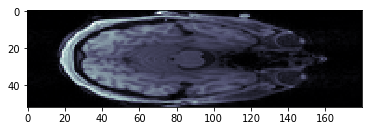

In [5]:
pylab.imshow(cr_data[:,:,100], cmap='bone')

___

## Understanding a dicom image better

In [6]:
dcm = dicom.read_file('affineTests/series0017/RESEARCH_YC_171024.MR.PRISMA_HEAD.0017.0039.2017.10.24.12.31.58.663479.31906623.IMA')

In [7]:
pixel_array = dcm.pixel_array
pixel_array.shape

(192, 180)

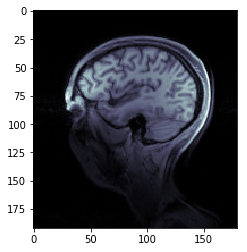

In [8]:
pylab.imshow(pixel_array, cmap='bone')

In [9]:
print('Rows: {}'.format(dcm.Rows))
print('Cols: {}'.format(dcm.Columns))

Rows: 192
Cols: 180


In [10]:
dcm.ImageOrientationPatient

['0.05582150293994', '0.99844076429677', '2.5254742e-008', '0.04006922781776', '-0.0022401922718', '-0.9991943947604']

The tag ImageOrientationPatient indicates the **direction cosines** for the row axis (first 3 values: cosines along x,y,z) and column axis (last 3 values: cosines along x,y,z). 

The XYZ axes of the DICOM coordinate system are specified as LPS+. Thus, the direction that the row axis of the image (i.e. the axis that points from 0-> + along the first row) with respect to the LPS+ coordinate system is given by:

* cos(x) - cosine wrt the x-axis
* cos(y) - cosine wrt the y-axis
* cos(z) - cosine wrt the z-axis


---
## Understanding rotation matrices

In [23]:
from skimage import transform

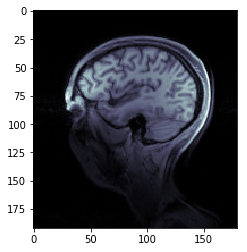

In [24]:
plt.imshow(pixel_array, cmap='bone')

#### First, try a basic rotation of the row axis:

In [25]:
# rotate it by 10 deg ccw
R = transform.AffineTransform(rotation=np.radians(10))
R.params

array([[ 0.985, -0.174,  0.   ],
       [ 0.174,  0.985,  0.   ],
       [ 0.   ,  0.   ,  1.   ]])

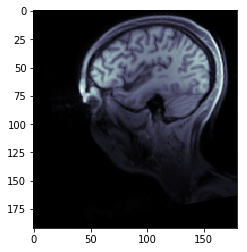

In [26]:
pix_rot = transform.warp(pixel_array, R)
plt.imshow(pix_rot, cmap='bone')

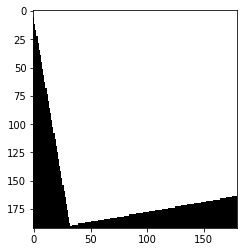

In [28]:
# try with an array of 1s as well to better visualize
test = np.ones(shape=pixel_array.shape)
test_rot = transform.warp(test, R)
plt.imshow(test_rot, cmap='bone')

### Ok, now try rotating using the matrix obtained from the imageOrientationPatient field

In [29]:
# obtain the imageOrientationPatient
iop = dcm.ImageOrientationPatient
iop

['0.05582150293994', '0.99844076429677', '2.5254742e-008', '0.04006922781776', '-0.0022401922718', '-0.9991943947604']

The first 3 values represent cosines for the row axis, the second 3 values represent cosines for the column axis. Since we're only concerned with 2D for the moment, make a 

In [30]:
iop = np.array(iop).reshape(2,3).T

In [31]:
iop

array([[ 0.056,  0.04 ],
       [ 0.998, -0.002],
       [ 0.   , -0.999]])

In [32]:
iop_R = np.eye(3)
iop_R[:2,:2] = iop[:2, :2]
iop_R

array([[ 0.056,  0.04 ,  0.   ],
       [ 0.998, -0.002,  0.   ],
       [ 0.   ,  0.   ,  1.   ]])

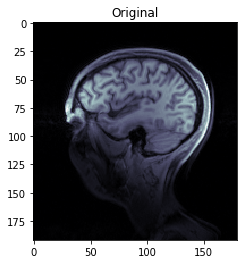

In [34]:
plt.title('Original')
plt.imshow(pixel_array, cmap='bone')

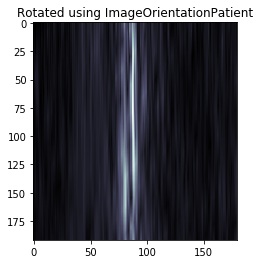

In [35]:
# rotate
pix_rot = transform.warp(pixel_array, iop_R)
pix_rot.shape

plt.title('Rotated using ImageOrientationPatient')
plt.imshow(pix_rot, cmap='bone')

This looks like the image has been rotated into the plane perpendicular to the screen (maybe along the row-axis?). This would be consistent with the goal of bring the X-axis (the row-axis) into the LEFT -> RIGHT orientation wrt the subject. 

---
But wait, the pixel_array is a numpy array, meaning it's indexed like (row, col), meaning that the first index refers to the *column-axis* (i.e. the axis that goes down the first column). The first column of the rotation matrix has the directional cosines for the *row-axis*. In order to correct this, we need to swap the first two columns of the rotation matrix 

In [36]:
# orig matrix
iop_R

array([[ 0.056,  0.04 ,  0.   ],
       [ 0.998, -0.002,  0.   ],
       [ 0.   ,  0.   ,  1.   ]])

In [37]:
# swapped matrix
iop_R_swapped = iop_R[:,[1,0,2]]
iop_R_swapped

array([[ 0.04 ,  0.056,  0.   ],
       [-0.002,  0.998,  0.   ],
       [ 0.   ,  0.   ,  1.   ]])

Now, apply this new rotation matrix to the pixel array

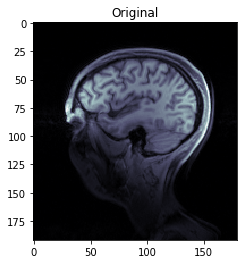

In [38]:
plt.title('Original')
plt.imshow(pixel_array, cmap='bone')

Sum across rows. This would be what it would look like (kind of) if you grabbed the column axis and pulled it 90deg out from the plane of the screen

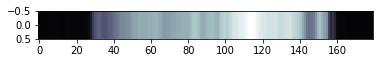

In [69]:
colAxis_mean = np.mean(pixel_array, axis=0)
plt.imshow(colAxis_mean[np.newaxis,:], cmap="bone", aspect=15)

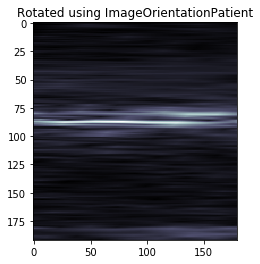

In [71]:
# rotate
pix_rot = transform.warp(pixel_array, iop_R_swapped)
plt.title('Rotated using ImageOrientationPatient')
plt.imshow(pix_rot, cmap='bone')

This looks consistent with rotating the rowAxis of pixel_array into the plane of the screen. Let's assume that `iop_R_swapped` will rotate the slice image (represented by `pixel_array`) into the right orientation in LPS+ DICOM space

# Working with 3D volume

Ok, so far it seems like we can use the dicom tag ImageOrientationPatient to build a rotation matrix that will successfully rotate the pixel_array from the DICOM file into LPS+ orientation. 

**Next step**:
Expand on those ideas to build the affine transformation matrix that will reorient a 3D array into LPS+ space

Certain fields of the transformation matrix will be the same regardless of what slice you're working with. That is, ImageOrientationPatient should be exactly the same for all slices. We can start building the affine using the values taken from the first slice

In [81]:
firstSlice_fname = 'affineTests/series0017/RESEARCH_YC_171024.MR.PRISMA_HEAD.0017.0001.2017.10.24.12.31.58.663479.31905939.IMA'
dcm_first = dicom.read_file(firstSlice_fname)
print('slice #: {}'.format(dcm_first.InstanceNumber))

slice #: 1


### Start the affine

In [85]:
affine = np.zeros((4,4))
affine

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

The first 3 rows of the **first** column will represent the *direction cosines* for the column-axis. That is, the axis that points ALONG a single column (passing OVER rows) 

The first 3 rows of the **second** column will represent the *direction cosines* for the row-axis. That is, the axis that points ALONG a single row (passing OVER columns)

**Note** Remember, the order of these columns in the affine matrix is reversed from what the DICOM specifications say (DICOM specifics say that the first column should represent direction cosines of the row-axis, and the second column should reprsent direction cosines for the column axis). We are swapping that because our pixel data for each slice will be reprented as a numpy array with (row, col) indexing, whereas DICOM expects (col, row) indexing (or in other words, (x,y)). 

### Populate the affine with the ImageOrientationPatient info
Use the info from the first slice

In [98]:
# extract the reformat the ImageOrientationPatient Info
iop = dcm_first.ImageOrientationPatient

print(iop)

# reshape the image orientation patient
iop = np.array(iop).reshape(3,2, order='F')
print('orig -----')
print(iop)

# swap the columns
iop = iop[:,[1,0]]
print('swapped -----')
print(iop)

['0.05582150293994', '0.99844076429677', '2.5254742e-008', '0.04006922781776', '-0.0022401922718', '-0.9991943947604']
orig -----
[[ 0.056  0.04 ]
 [ 0.998 -0.002]
 [ 0.    -0.999]]
swapped -----
[[ 0.04   0.056]
 [-0.002  0.998]
 [-0.999  0.   ]]


The direction cosines need to be multiplied by the pixel spacing along each direction. The DICOM tag PixelSpacing has 2 values: 

* pixel spacing between adjacent ROWS
* pixel spacing between adjacent COLS


In [100]:
pixelSpacing = dcm_first.PixelSpacing
print('adjacent rows (i.e. Vertical) resolution: {}'.format(pixelSpacing[0]))
print('adjacent cols (i.e. Horiz) resolution: {}'.format(pixelSpacing[1]))

adjacent rows (i.e. Vertical) resolution: 1.3333333730698
adjacent cols (i.e. Horiz) resolution: 1.3333333730698


The column-axis directional cosines need to be multiplied by the vertical resolution of the image:

In [101]:
iop[:,0] = iop[:,0] * pixelSpacing[0]
iop

array([[ 0.053,  0.056],
       [-0.003,  0.998],
       [-1.332,  0.   ]])

The row-axis directional cosines need to be multiplied by the horizontal resolution of the image:

In [102]:
iop[:,1] = iop[:,1] * pixelSpacing[1]
iop

array([[ 0.053,  0.074],
       [-0.003,  1.331],
       [-1.332,  0.   ]])

Current state of the affine:

In [109]:
affine[:3,:2] = iop
affine

array([[ 0.053,  0.074,  0.   ,  0.   ],
       [-0.003,  1.331,  0.   ,  0.   ],
       [-1.332,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ]])

### Next step is to insert the imagePositionPatient info

The fourth column of the affine matrix will specify the translation needed to take the origin of the DICOM refernce coordinate system

It can be obtained from the ImagePositionPatient field of the first slice

In [111]:
ipp = dcm_first.ImagePositionPatient
print(ipp)

['-88.150703580322', '-134.38821883415', '59.742053192921']


In [112]:
affine[:3,3] = ipp
affine

array([[   0.053,    0.074,    0.   ,  -88.151],
       [  -0.003,    1.331,    0.   , -134.388],
       [  -1.332,    0.   ,    0.   ,   59.742],
       [   0.   ,    0.   ,    0.   ,    0.   ]])

### Now we need to figure out the 3rd column of the affine matrix
The 3rd column will represent info about the Z dimension of our image matrix. It can be filled by taking the difference in ImagePositionPatient between the first and last slice, and dividing by the total number of slices. 

In [125]:
# read in the last slice
lastSlice_fname = 'affineTests/series0017/RESEARCH_YC_171024.MR.PRISMA_HEAD.0017.0052.2017.10.24.12.31.58.663479.31906857.IMA'
dcm_last = dicom.read_file(lastSlice_fname)

In [115]:
ipp_first = dcm_first.ImagePositionPatient
ipp_last = dcm_last.ImagePositionPatient

ipp_diff = np.array(ipp_first)-np.array(ipp_last)
ipp_diff

array([-152.638,    8.534,   -6.14 ])

In [119]:
# divide each value by 1-nSlices
ipp_diffBySlice = ipp_diff/(1-dcm_last.InstanceNumber)
ipp_diffBySlice

array([ 2.993, -0.167,  0.12 ])

In [120]:
# place in the affine
affine[:3,2] = ipp_diffBySlice
affine

array([[   0.053,    0.074,    2.993,  -88.151],
       [  -0.003,    1.331,   -0.167, -134.388],
       [  -1.332,    0.   ,    0.12 ,   59.742],
       [   0.   ,    0.   ,    0.   ,    0.   ]])

In [123]:
# add 1 in the last spot for affine
affine[3,3] = 1
affine

array([[   0.053,    0.074,    2.993,  -88.151],
       [  -0.003,    1.331,   -0.167, -134.388],
       [  -1.332,    0.   ,    0.12 ,   59.742],
       [   0.   ,    0.   ,    0.   ,    1.   ]])

In [154]:
nib.aff2axcodes(affine)

('I', 'A', 'R')

### Affine now represents the affine matrix needed to take the 3D image array to LPS+

Now try to actually build that image matrix

In [126]:
import glob

In [128]:
sliceFiles = glob.glob('affineTests/series0017/*.IMA')
len(sliceFiles)

52

In [131]:
# loop over all images, extract pixel_array, add to 3D array
for i,sl in enumerate(sliceFiles):
    
    # load the file
    dcm = dicom.read_file(join('.', sl))
    
    # get the pixel info
    pixel_array = dcm.pixel_array
    
    if i == 0:
        # preallocate an empty matrix to store all slices
        imageMatrix = np.zeros(shape=(pixel_array.shape[0], 
                                       pixel_array.shape[1], 
                                       len(sliceFiles))
                               )
    
    # get slice index
    slIdx = int(dcm.InstanceNumber) - 1
    
    # add slice to matrix
    imageMatrix[:,:,slIdx] = pixel_array

imageMatrix.shape

(192, 180, 52)

**Note** The resulting imageMatrix has voxels ordered like: [rows, cols, slices] corresponding to Inferior, Posterior, Left 

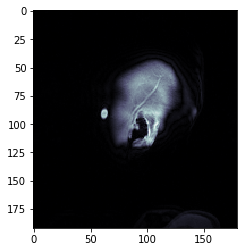

In [152]:
plt.imshow(imageMatrix[:,:,48], cmap='bone')

In [84]:
dcm_last.ImageOrientationPatient

['0.05582150293994', '0.99844076429677', '2.5254742e-008', '0.04006922781776', '-0.0022401922718', '-0.9991943947604']